# Error Attribution

In this notebook, we do 2 things:
1. filter out error case (gpt-4o, C1, C2), pre-define some error types, and then manually review and catogories them, output 2 table of error types and 2 figure of error distribution, to show some insights.
2. find suitable correct case and error case (gpt-4o, C1, C2), for illustration.

> Note that, our default model is `gpt-4o`, for C1: 120 samples, for C2: 80 samples; each split has 20 samples

In [65]:
from pathlib import Path

res_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/result/")

In [66]:
res_file = res_dir / "main_results.jsonl"

import pandas as pd

data = pd.read_json(res_file, lines=True)

filter out gpt-4o

In [67]:
data.columns

Index(['scene', 'pair', 'tx', 'ty', 'tz', 'theta', 'phi', 'psi', 'tx_text',
       'ty_text', 'tz_text', 'theta_text', 'phi_text', 'psi_text',
       'significance', 'significance_text', 'significance_value', 'rsn',
       'pred', 'label', 'is_correct', 'is_parse', 'round', 'task', 'model',
       'dataset', 'eval_metric', 'prompt_level', 'is_trap', 'seq', 'hash_id',
       'pred_val', 'label_val', 'is_valid', 'distance', 'angle', 'tau'],
      dtype='object')

In [68]:
data = data[data["model"] == "gpt-4o"]

In [69]:
data = data[data["is_correct"] == False]

In [70]:
data = data[data["is_trap"] == False]

In [71]:
data = data[data["is_parse"] == True]

In [72]:
c1 = data[data["task"] == "c1"]
c2 = data[data["task"] == "c2"]

nice funcs for both c1 and c2

In [73]:
num_of_samples = 20

def _filter(data, num_of_samples, split_name):
    seed = 42
    filter_data = pd.DataFrame()
    filter_list = data[split_name].unique()
    for subset in filter_list:
        subset_data = data[data[split_name] == subset]
        if len(subset_data) > num_of_samples:
            subset_data = subset_data.sample(num_of_samples, random_state=seed)
        filter_data = pd.concat([filter_data, subset_data])
    return filter_data


In [74]:
c1_dataset = _filter(c1, num_of_samples, "eval_metric")
c2_dataset = _filter(c2, num_of_samples, "tau")

In [75]:
c1_dataset["eval_metric"].value_counts()

eval_metric
tz       20
tx       20
phi      20
psi      20
ty       20
theta    20
Name: count, dtype: int64

In [76]:
c2_dataset["tau"].value_counts()

tau
min-angle-60-deg    20
min-angle-45-deg    20
min-angle-15-deg    20
min-angle-30-deg    20
Name: count, dtype: int64

In [77]:
pd.qcut(c2_dataset["angle"], 4).value_counts()

angle
(15.027000000000001, 30.05]    20
(30.05, 45.297]                20
(45.297, 63.155]               20
(63.155, 102.871]              20
Name: count, dtype: int64

## Manually Review

To be specific, the error types are following:
1. PE -- perception error: xxx
2. SRE -- spatial relation error: xxx
3. LRE -- logical reasoning error: xxx
4. PTE -- perspective transformation error: xxx
5. full name for other errors

In [78]:
res_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/result")
res_dir = res_dir / "error-attribution"
res_dir.mkdir(exist_ok=True, parents=True)

In [79]:
c1_dataset.head()

,scene,pair,tx,ty,tz,theta,phi,psi,tx_text,ty_text,...,prompt_level,is_trap,seq,hash_id,pred_val,label_val,is_valid,distance,angle,tau
13630,scene0789_00,000671-000690,-0.078962,-0.035289,0.410650,1.217677,0.165456,1.330545,left,up,...,dataset-prior-hint,0.0,None,None,NaN,NaN,NaN,NaN,NaN,None
22952,None,009358-009373,0.144591,-0.050708,0.415012,-3.263284,4.765806,1.751698,right,up,...,zero-shot,0.0,None,578511c8a9,NaN,NaN,NaN,NaN,NaN,None
13873,scene0783_00,001519-001546,0.041767,0.039552,0.408483,-0.962937,-1.202116,2.628469,right,down,...,zero-shot,0.0,None,None,NaN,NaN,NaN,NaN,NaN,None
13623,scene0709_00,000450-000478,0.058965,-0.077797,0.407738,-1.108655,3.592630,-2.971862,right,up,...,dataset-prior-hint,0.0,None,None,NaN,NaN,NaN,NaN,NaN,None
14331,scene0709_00,000450-000478,0.058965,-0.077797,0.407738,-1.108655,3.592630,-2.971862,right,up,...,VoT-hint,0.0,None,None,NaN,NaN,NaN,NaN,NaN,None


In [80]:
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from glob import glob
import re

start_sample = 94 # TODO: start index of samples
i = start_sample

def row_iterator(df):
    length = df.shape[0]
    global i
    for _, row in df.iloc[start_sample-1:].iterrows():
        print(f"Processing row {i}/{length}")
        i += 1
        yield row

def read_image_files(row):
    # 7-scenes and scanet use scene-pair
    # scannetpp use hash_id-pair
    bench_dir = Path("/home/u5u/kdeng.u5u/benchmark")
    prefix = "single-dof-camera-motion-"
    dataset_dir = prefix + row["dataset"]
    dof_suffix = "_significant"
    dof_dir = row["significance"] + dof_suffix

    if row["dataset"] == "7-scenes":
        scene_dir = row["scene"]
        image_dir = bench_dir / dataset_dir / dof_dir / scene_dir / row["seq"] / row["pair"]
        src_img_path = list((image_dir / "source").glob("*.color.png"))[0]
        tgt_img_path = list((image_dir / "target").glob("*.color.png"))[0]
        return src_img_path, tgt_img_path
    elif row["dataset"] == "scannet":
        scene_dir = row["scene"]
        image_dir = bench_dir / dataset_dir / dof_dir / scene_dir / row["pair"]
        src_img_path = list((image_dir / "source").glob("*.jpg"))[0]
        tgt_img_path = list((image_dir / "target").glob("*.jpg"))[0]
        return src_img_path, tgt_img_path
    elif row["dataset"] == "scannetpp":
        scene_dir = row["hash_id"]
        image_dir = bench_dir / dataset_dir / dof_dir / scene_dir / row["pair"]
        src_img_path = list((image_dir / "source").glob("*.jpg"))[0]
        tgt_img_path = list((image_dir / "target").glob("*.jpg"))[0]
        return src_img_path, tgt_img_path
    else:
        print(f"No scene directory found for dataset: {row['dataset']}")


def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
    title_list = ["Source", "Target"]
    for i, img in enumerate(images):
        ax = axes[i]
        ax.imshow(Image.open(img))
        ax.axis("off")
        ax.set_title(title_list[i])
    plt.show()


def read_chat(row):
    res_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/result/final-table-wo-trap/single-dof-cls")

    chat_file = res_dir / row["dataset"] / "gpt-4o" / row["prompt_level"] / row["significance"] / "chat_history.jsonl"
    df = pd.read_json(chat_file, lines=True)
    if row["dataset"] in ["7-scenes", "scannet"]:
        chat = df[(df["scene"] == row["scene"]) & (df["pair"] == row["pair"])]
    elif row["dataset"] == "scannetpp":
        chat = df[(df["hash_id"] == row["hash_id"]) & (df["pair"] == row["pair"])]
    else:
        print(f"No chat history found for dataset: {row['dataset']}")
    return chat.squeeze()


def show_qa(chat):
    print(f"Significance: {chat['significance']}\nLabel: {chat['significance_text']}")
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 1, height_ratios=[0.2, 0.8])
    ax1 = fig.add_subplot(gs[0])
    ax1.axis("off")
    ax1.text(0, 1, chat["raw_output"], va="center", ha="left", wrap=True, fontname="serif", fontsize="small", backgroundcolor="#7fc97f")

    ax2 = fig.add_subplot(gs[1])
    ax2.axis("off")
    text = re.sub(r'\n\s+', '\n', chat["prompt"])
    ax2.text(0, 0.5, text, va="center", ha="left", wrap=True, fontsize="small", fontname="serif", backgroundcolor="#beaed4")
    
    plt.show()

c1_iter = row_iterator(c1_dataset)

In [81]:
# import jsonlines

# row = next(c1_iter)

# show_images(read_image_files(row))

# show_qa(read_chat(row))

# # label the sample
# ref_obj = input("🔍🔍 Enter REF OBJ: ")
# num_of_ref_obj = len(ref_obj.split(","))
# error_type = input("💡💡 Enter ERROR TYPE for IMAGES (grounding: PE, SRE; inference: LRE, PTE): ")

# # save result
# with jsonlines.open(res_dir / "error_attribution.jsonl", mode='a') as writer:
#     writer.write({
#         **row,
#         "num_of_ref_obj": num_of_ref_obj,
#         "ref_obj": ref_obj.lower().split(","),
#         "error_type": error_type.split(","),
#     })

# print(f"Finished processing row with num of ref obj: {num_of_ref_obj}, ref obj: {ref_obj}, error type: {error_type}")

## Manually Review C2

In [82]:
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from glob import glob
import re

start_sample = 1 # TODO: start index of samples
i = start_sample

def row_iterator(df):
    length = df.shape[0]
    global i
    for _, row in df.iloc[start_sample-1:].iterrows():
        print(f"Processing row {i}/{length}")
        i += 1
        yield row

def read_image_files(row):
    # 7-scenes and scanet use scene-pair
    # scannetpp use hash_id-pair
    bench_dir = Path("/home/u5u/kdeng.u5u/benchmark")
    prefix = "obj-centered-view-shift-"
    dataset_dir = prefix + row["dataset"]

    if row["dataset"] == "7-scenes":
        scene_dir = row["scene"]
        image_dir = bench_dir / dataset_dir / row["tau"] / scene_dir / row["seq"] / row["pair"]
        src_img_path = list((image_dir / "source").glob("*.color.png"))[0]
        tgt_img_path = list((image_dir / "target").glob("*.color.png"))[0]
        return src_img_path, tgt_img_path
    elif row["dataset"] == "scannet":
        scene_dir = row["scene"]
        image_dir = bench_dir / dataset_dir / row["tau"] / scene_dir / row["pair"]
        src_img_path = list((image_dir / "source").glob("*.jpg"))[0]
        tgt_img_path = list((image_dir / "target").glob("*.jpg"))[0]
        return src_img_path, tgt_img_path
    else:
        print(f"No scene directory found for dataset: {row['dataset']}")


def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
    title_list = ["Source", "Target"]
    for i, img in enumerate(images):
        ax = axes[i]
        ax.imshow(Image.open(img))
        ax.axis("off")
        ax.set_title(title_list[i])
    plt.show()


def read_chat(row):
    res_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/result/final-table-wo-trap/obj-centered-cls")

    chat_file = res_dir / row["eval_metric"] / row["dataset"] / "gpt-4o" / row["tau"] / "chat_history.jsonl"
    df = pd.read_json(chat_file, lines=True)
    if row["dataset"] in ["7-scenes", "scannet"]:
        chat = df[(df["scene"] == row["scene"]) & (df["pair"] == row["pair"])]
    elif row["dataset"] == "scannetpp":
        chat = df[(df["hash_id"] == row["hash_id"]) & (df["pair"] == row["pair"])]
    else:
        print(f"No chat history found for dataset: {row['dataset']}")
    return chat.squeeze()


def show_qa(chat):
    print(f"Angle: {chat['angle']}\nTx: {chat['tx_text']}\nPhi: {chat['phi_text']}")
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 1, height_ratios=[0.2, 0.8])
    ax1 = fig.add_subplot(gs[0])
    ax1.axis("off")
    ax1.text(0, 1, chat["raw_output"], va="center", ha="left", wrap=True, fontname="serif", fontsize="small", backgroundcolor="#7fc97f")

    ax2 = fig.add_subplot(gs[1])
    ax2.axis("off")
    text = re.sub(r'\n\s+', '\n', chat["prompt"])
    ax2.text(0, 0.5, text, va="center", ha="left", wrap=True, fontsize="small", fontname="serif", backgroundcolor="#beaed4")
    
    plt.show()

c2_iter = row_iterator(c2_dataset)

Processing row 1/80


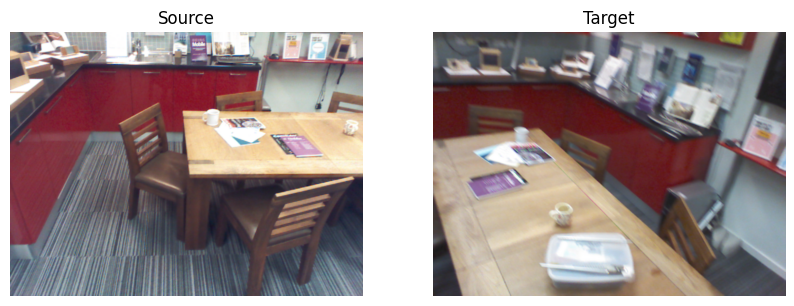

Angle: 66.200527
Tx: right
Phi: leftward


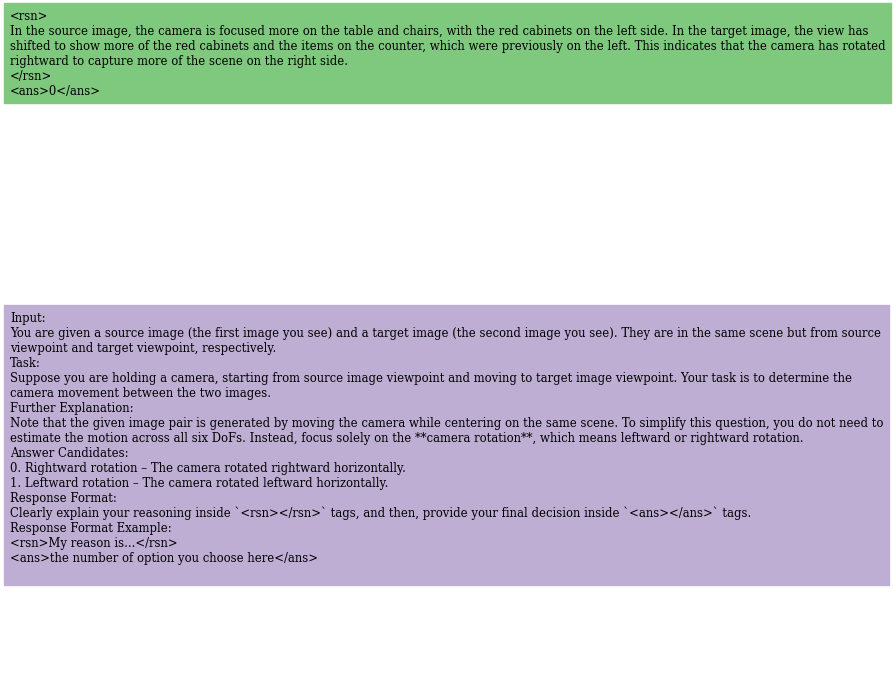

Finished processing row with num of ref obj: 1, ref obj: , error type: 


In [83]:
import jsonlines

row = next(c2_iter)

show_images(read_image_files(row))

show_qa(read_chat(row))

# label the sample
ref_obj = input("🔍🔍 Enter REF OBJ: ")
num_of_ref_obj = len(ref_obj.split(","))
error_type = input("💡💡 Enter ERROR TYPE for IMAGES (grounding: PE, SRE; inference: LRE, PTE): ")

# save result
with jsonlines.open(res_dir / "error_attribution.jsonl", mode='a') as writer:
    writer.write({
        **row,
        "num_of_ref_obj": num_of_ref_obj,
        "ref_obj": ref_obj.lower().split(","),
        "error_type": error_type.split(","),
    })

print(f"Finished processing row with num of ref obj: {num_of_ref_obj}, ref obj: {ref_obj}, error type: {error_type}")

# Case Study